####  Setup and Imports

In [342]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import neattext.functions as nfx
from textblob import TextBlob
from collections import Counter
from wordcloud import WordCloud
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import joblib
import eli5

#### Data Loading and Initial Exploration

In [343]:
df = pd.read_csv('data/emotion_dataset_2.csv')
# preview
df.head()

,Unnamed: 0,Emotion,Text,Clean_Text
0,0,neutral,Why ?,NaN
1,1,joy,Sage Act upgrade on my to do list for tommorow.,Sage Act upgrade list tommorow
2,2,sadness,ON THE WAY TO MY HOMEGIRL BABY FUNERAL!!! MAN ...,WAY HOMEGIRL BABY FUNERAL MAN HATE FUNERALS SH...
3,3,joy,Such an eye ! The true hazel eye-and so brill...,eye true hazel eyeand brilliant Regular feat...
4,4,joy,@Iluvmiasantos ugh babe.. hugggzzz for u .! b...,ugh babe hugggzzz u babe naamazed nga ako e...


In [344]:
df.shape

(34792, 4)

In [345]:
df.dtypes

Unnamed: 0     int64
Emotion       object
Text          object
Clean_Text    object
dtype: object

In [346]:
df.isnull().sum()

Unnamed: 0      0
Emotion         0
Text            0
Clean_Text    466
dtype: int64

In [347]:
# value Counts of Emotions
df['Emotion'].value_counts()

Emotion
joy         11045
sadness      6722
fear         5410
anger        4297
surprise     4062
neutral      2254
disgust       856
shame         146
Name: count, dtype: int64

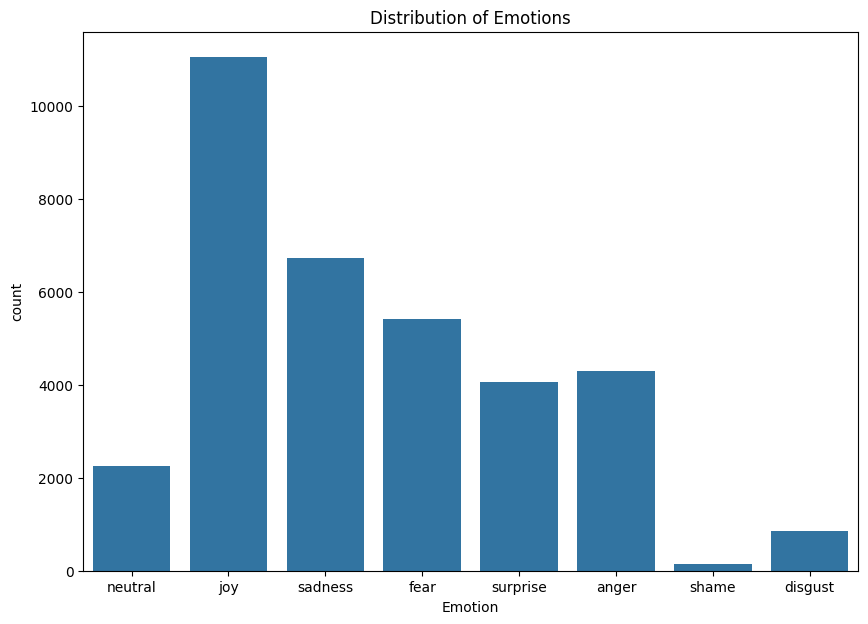

In [348]:
# Vallue Counts of Emotions
plt.figure(figsize=(10, 7))
sns.countplot(x='Emotion', data=df)
plt.title('Distribution of Emotions')
plt.show()

#### Text Proprocessing


In [349]:
# Function to remove stopwords
def remove_stopwords(text):
    return nfx.remove_stopwords(text)

# Function to remove special characters
def remove_special_characters(text):
    return nfx.remove_special_characters(text)

# Function to remove punctuations
def remove_punctuations(text):
    return nfx.remove_punctuations(text)

In [350]:
df['Clean_Text'] = df['Text'].apply(remove_stopwords)
df['Clean_Text'] = df['Clean_Text'].apply(remove_special_characters)
df['Clean_Text'] = df['Clean_Text'].apply(remove_punctuations)

In [351]:
df.head()

,Unnamed: 0,Emotion,Text,Clean_Text
0,0,neutral,Why ?,
1,1,joy,Sage Act upgrade on my to do list for tommorow.,Sage Act upgrade list tommorow
2,2,sadness,ON THE WAY TO MY HOMEGIRL BABY FUNERAL!!! MAN ...,WAY HOMEGIRL BABY FUNERAL MAN HATE FUNERALS SH...
3,3,joy,Such an eye ! The true hazel eye-and so brill...,eye true hazel eyeand brilliant Regular feat...
4,4,joy,@Iluvmiasantos ugh babe.. hugggzzz for u .! b...,Iluvmiasantos ugh babe hugggzzz u babe naamaz...


#### Feature Engineering

In [352]:
def extract_keywords(text_data, num_keywords=50):
    total_keywords = Counter()
    for text in text_data:
        if isinstance(text, str):
            words = text.split()
            total_keywords.update(words)
    return total_keywords.most_common(num_keywords)

In [353]:
joy_list = df[df['Emotion'] == 'joy']['Clean_Text'].tolist()
joy_docx = ' '.join([str(item) for item in joy_list]) 
keyword_joy = extract_keywords(joy_docx)
keyword_joy

[('e', 54972),
 ('a', 36552),
 ('i', 34188),
 ('o', 33861),
 ('t', 33323),
 ('n', 31890),
 ('s', 30733),
 ('r', 29093),
 ('l', 23842),
 ('d', 19341),
 ('h', 16348),
 ('g', 15939),
 ('m', 15091),
 ('c', 14442),
 ('p', 12795),
 ('u', 12661),
 ('y', 11659),
 ('w', 7985),
 ('f', 7604),
 ('k', 7433),
 ('b', 6431),
 ('v', 4648),
 ('T', 1984),
 ('S', 1969),
 ('C', 1793),
 ('I', 1614),
 ('x', 1545),
 ('L', 1473),
 ('A', 1378),
 ('B', 1319),
 ('G', 1298),
 ('j', 1280),
 ('M', 1257),
 ('E', 1193),
 ('R', 1080),
 ('O', 1073),
 ('H', 1063),
 ('D', 1059),
 ('q', 998),
 ('P', 940),
 ('1', 905),
 ('F', 893),
 ('W', 844),
 ('z', 788),
 ('N', 773),
 ('0', 759),
 ('2', 759),
 ('J', 673),
 ('3', 546),
 ('U', 540)]

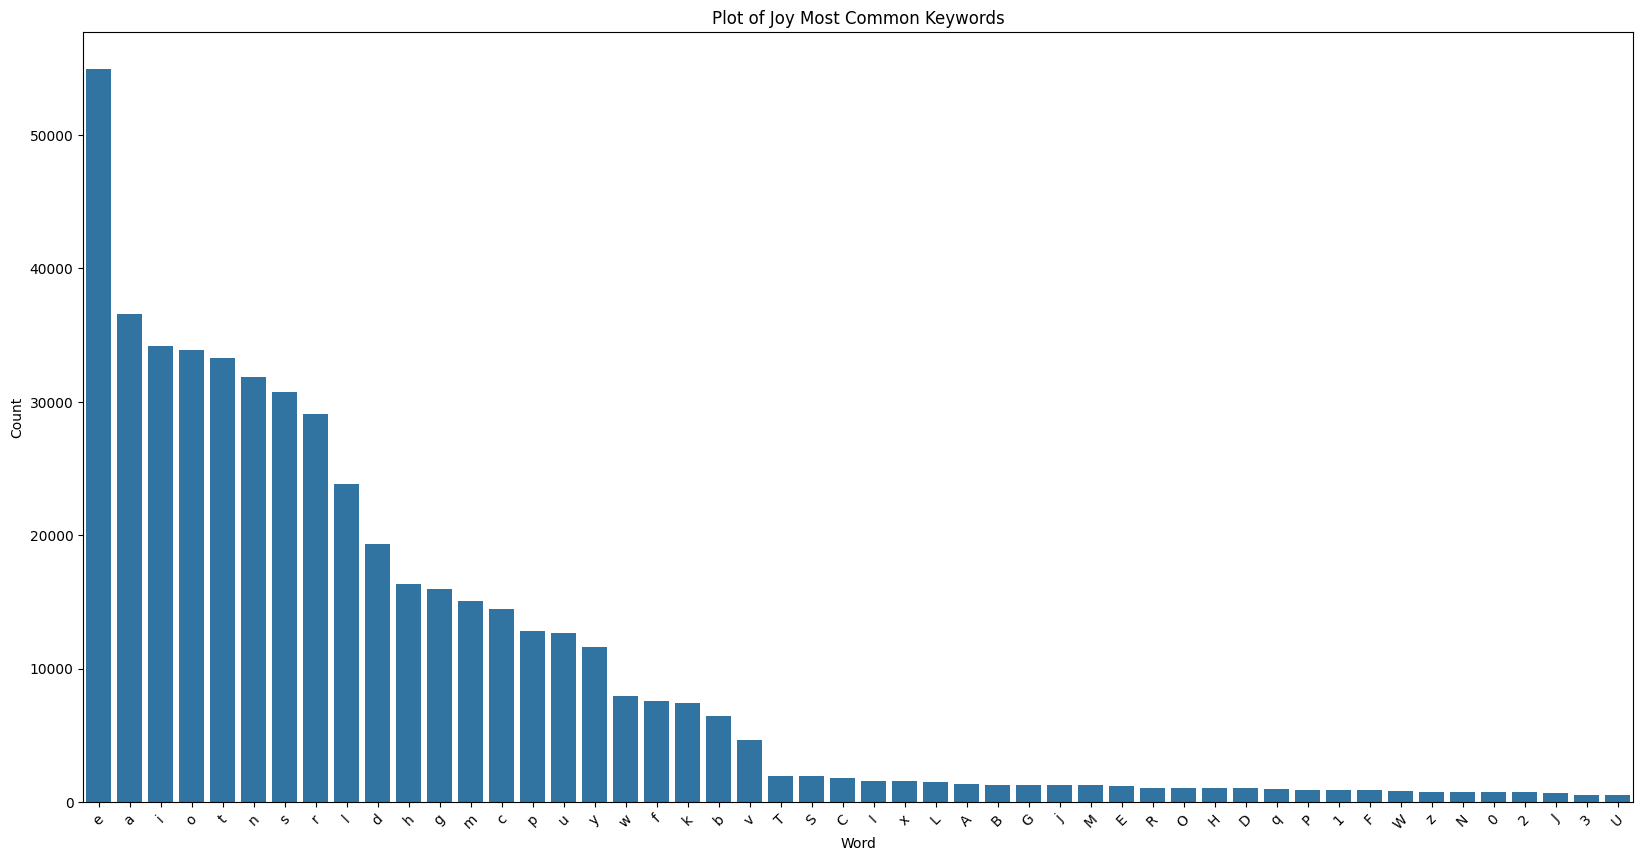

In [354]:
def plot_most_common_words(mydict, emotion_name):
    df_01 = pd.DataFrame(mydict, columns=['Word', 'Count'])
    plt.figure(figsize=(20, 10))
    plt.title("Plot of {} Most Common Keywords".format(emotion_name))
    sns.barplot(x='Word', y='Count', data=df_01)
    plt.xticks(rotation=45)
    plt.show()

# Example usage for joy keywords
plot_most_common_words(keyword_joy, 'Joy')

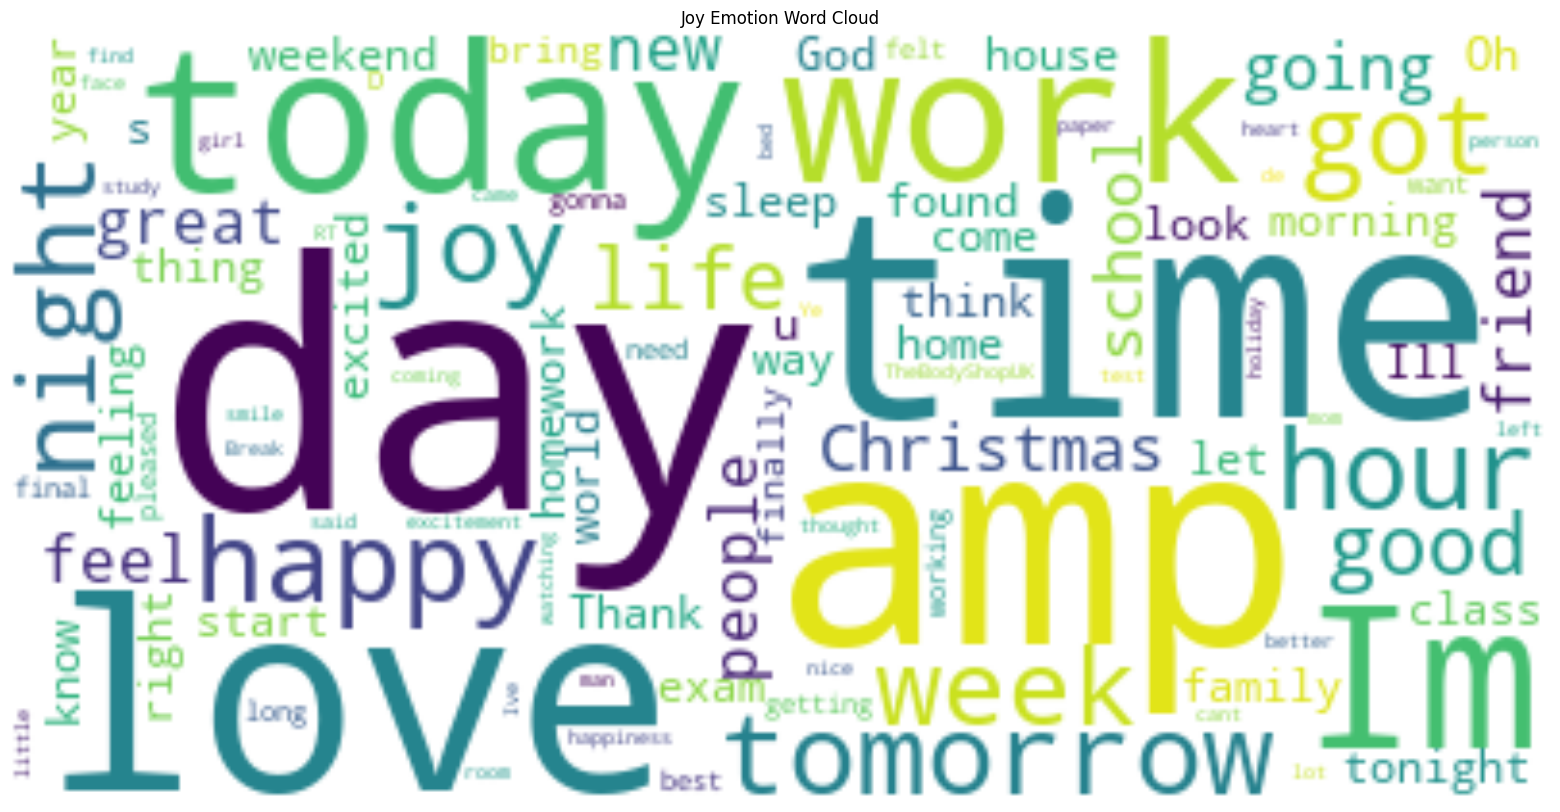

In [355]:
# For 'joy' emotion
plt.figure(figsize=(20, 10))
wordcloud = WordCloud(max_words=100, background_color="white").generate(joy_docx)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Joy Emotion Word Cloud")
plt.show()

In [356]:
Xfeatures = df['Clean_Text']
ylabels = df['Emotion']

# Split data
X_train, X_test, y_train, y_test = train_test_split(Xfeatures, ylabels, test_size=0.3, random_state=42)

In [357]:
cv = CountVectorizer()
X_train_cv = cv.fit_transform(X_train.astype('U')) # Use .astype('U') to handle mixed types
X_test_cv = cv.transform(X_test.astype('U'))

In [358]:
joy_list = df[df['Emotion'] == 'joy']['Clean_Text'].tolist()
# Joy document
joy_docx = ' '.join(joy_list)
joy_docx


'Sage Act upgrade list tommorow eye  true hazel eyeand brilliant  Regular features  open countenance  complexion  Oh  bloom health  pretty height size  firm upright figure  health  merely bloom  air  head  glance  hears child  picture health    gives idea complete picture grownup health  loveliness  Iluvmiasantos ugh babe hugggzzz u  babe naamazed nga ako e babe e despite negas mas pinaramdam fil ko ang life  Leopold truly happy  hopes prayers beloved son come fruition  feeling fail french fuckfrench GoodLet   fell love X Overnight felt confidence selfesteem responsible worthwhile terribly ecstatic dangerous thing  selected study university Yeah   ages   passed BA exams class results heard selected fot year university Zambia form Chikola secondary school Welp time study days Heading campus rain grad photos feeling awesome  TheBodyShopUK brings  Ive bought Christmas presents trawl loads shops  shit pants Pure 100 gravy life  Leopold truly happy  hopes prayers beloved son come fruition  

#### Model Training and Evaluation

C:\Users\Yonas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:1288: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


Logistic Regression Accuracy: 0.6246407357731366

Confusion Matrix:
 [[ 699    5   63  250   74  149    1   42]
 [  36   49   23   94    6   59    1   24]
 [  78    3 1080  256   30  130    0   68]
 [ 117    4  116 2563  110  252    1  148]
 [  14    0   10  111  477   54    0    9]
 [ 116    8   96  516   55 1149    1   74]
 [   0    0    0    5    0    1   30    0]
 [  58    6   53  431   23  136    1  473]]

Classification Report:
               precision    recall  f1-score   support

       anger       0.63      0.54      0.58      1283
     disgust       0.65      0.17      0.27       292
        fear       0.75      0.66      0.70      1645
         joy       0.61      0.77      0.68      3311
     neutral       0.62      0.71      0.66       675
     sadness       0.60      0.57      0.58      2015
       shame       0.86      0.83      0.85        36
    surprise       0.56      0.40      0.47      1181

    accuracy                           0.62     10438
   macro avg       

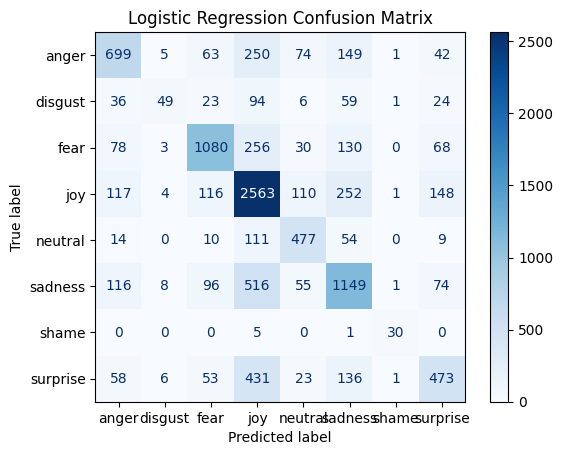

In [359]:
lr_model = LogisticRegression(solver='liblinear', max_iter=1000)
lr_model.fit(X_train_cv, y_train)
lr_predictions = lr_model.predict(X_test_cv)

print("Logistic Regression Accuracy:", accuracy_score(y_test, lr_predictions))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, lr_predictions))
print("\nClassification Report:\n", classification_report(y_test, lr_predictions))

# Display Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, lr_predictions), display_labels=lr_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Logistic Regression Confusion Matrix')
plt.show()

Naive Bayes Accuracy: 0.5677332822379766

Confusion Matrix:
 [[ 634    0   51  387    5  196    0   10]
 [  30    5   25  149    0   76    0    7]
 [  70    0 1001  364    1  156    0   53]
 [  66    0   93 2901    6  194    0   51]
 [  20    0   16  546   18   71    0    4]
 [  78    0   65  777    0 1065    0   30]
 [   9    0    7   15    0    5    0    0]
 [  49    0   45  654    0  131    0  302]]

Classification Report:
               precision    recall  f1-score   support

       anger       0.66      0.49      0.57      1283
     disgust       1.00      0.02      0.03       292
        fear       0.77      0.61      0.68      1645
         joy       0.50      0.88      0.64      3311
     neutral       0.60      0.03      0.05       675
     sadness       0.56      0.53      0.54      2015
       shame       0.00      0.00      0.00        36
    surprise       0.66      0.26      0.37      1181

    accuracy                           0.57     10438
   macro avg       0.59    

C:\Users\Yonas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Yonas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Yonas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_clas

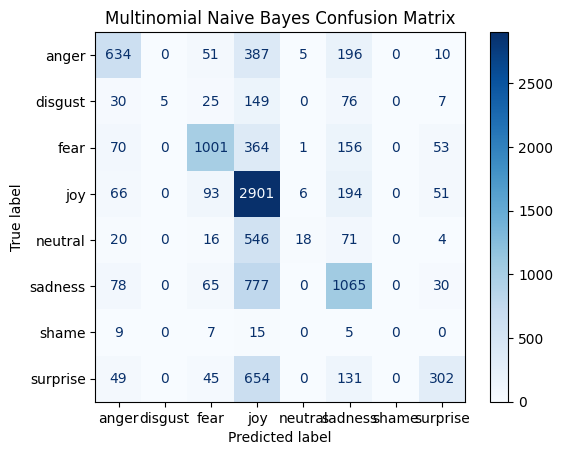

In [360]:
nv_model = MultinomialNB()
nv_model.fit(X_train_cv, y_train)
nv_predictions = nv_model.predict(X_test_cv)

print("Naive Bayes Accuracy:", accuracy_score(y_test, nv_predictions))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, nv_predictions))
print("\nClassification Report:\n", classification_report(y_test, nv_predictions))

# Display Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, nv_predictions), display_labels=nv_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Multinomial Naive Bayes Confusion Matrix')
plt.show()

#### Emotion Prediction and Explainability


In [365]:
def predict_emotion(text):
    clean_text = remove_stopwords(text)
    clean_text = remove_special_characters(clean_text)
    clean_text = remove_punctuations(clean_text)
    vectorized_text = cv.transform([clean_text])
    prediction = lr_model.predict(vectorized_text)[0]
    prediction_proba = lr_model.predict_proba(vectorized_text).max()
    return prediction, prediction_proba

In [366]:
text1 = "This is a good day"
emotion, prob = predict_emotion(text1)
print(f"Text: '{text1}' => Emotion: {emotion}, Probability: {prob:.2f}")


Text: 'This is a good day' => Emotion: joy, Probability: 0.53


In [ ]:
# Assuming lr_model and cv (CountVectorizer) are already defined and fitted

# Example text for explanation
text_to_explain = "I am so happy today, everything is going well."

# Transform the text using the fitted CountVectorizer
vec_text = cv.transform([text_to_explain])

# Show weights for Logistic Regression model
eli5.show_weights(lr_model, vec=cv, top=(20, 5))

####  Sentiment Analysis (TextBlob)

In [ ]:
def get_text_sentiment(text):
    return TextBlob(text).sentiment.polarity


In [ ]:
# Example Usage
text = "This is a very good movie."
sentiment = get_text_sentiment(text)
print(f"Text: '{text}' => Sentiment: {sentiment}")


Text: 'This is a very good movie.' => Sentiment: 0.9099999999999999


#### Model Saving

In [ ]:
# Save the model
joblib.dump(lr_model, 'emotion_detector_model.joblib')

# Save the CountVectorizer
joblib.dump(cv, 'count_vectorizer.joblib')

# To load them later:
# loaded_model = joblib.load('emotion_detector_model.joblib')
# loaded_vectorizer = joblib.load('count_vectorizer.joblib')

['count_vectorizer.joblib']